In [1]:
import cv2 as cv
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
bd_configPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector.cfg'
bd_weightsPath = 'models/bib_detector/RBNR2_custom-yolov4-tiny-detector_best.weights'
bd_classes = ['bib']

In [3]:
# True bounding box color
true_color = [15, 252, 75]
# Pred Bib bounding box color
color = [252, 15, 192]

In [4]:
class Detector:
    """
    Create YOLO object detection model in OpenCV with a given config and weights.
    Use this model to make predictions.
    
    Attributes
        classes (list): list of class names
        net (obj): openCV network object
        ln (obj): openCV layer names object
    """
    
    def __init__(self, cfg, wts, classes):
        """Initialize detector object
        
        Args
            cfg (str): path to model config file
            wts (str): path to model weights file
            classes (list): list of class names
        """
        
        self.classes = classes
        self.net = cv.dnn.readNetFromDarknet(cfg, wts)
        self.net.setPreferableBackend(cv.dnn.DNN_BACKEND_OPENCV)

        # determine the output layer
        self.ln = self.net.getLayerNames()
        self.ln = [self.ln[i - 1] for i in self.net.getUnconnectedOutLayers()]
        
    def detect(self, img, conf):
        """
        Make predictions and return classes and bounding boxes
        
        Args
            img (numpy array): image array from openCV .imread
            conf (float): prediction confidence threshold
            
        Returns
            List containing bounding box values and class names for detections
            in the form [<class name>, [x, y, width, height]]
        """
        
        #format image for detection
        blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)
        
         # get detections
        self.net.setInput(blob)
        outputs = self.net.forward(self.ln)

        # initialize lists
        boxes = []
        confidences = []
        classIDs = []

        # initialize image dimensions
        h_img, w_img = img.shape[:2]

        for output in outputs:
            for detection in output:
                scores = detection[5:]
                classID = np.argmax(scores)
                confidence = scores[classID]

                # drop low confidence detections and 
                if confidence > conf:
                    box = detection[:4] * np.array([w_img, h_img, w_img, h_img])
                    (centerX, centerY, width, height) = box.astype("int")
                    x = int(centerX - (width / 2))
                    y = int(centerY - (height / 2))
                    box = [x, y, int(width), int(height)]
                    boxes.append(box)
                    confidences.append(float(confidence))
                    classIDs.append(classID)

        # apply non maximal suppression for
        # initialize lists
        self.boxes = []
        self.confidences = []
        self.detected_classes = []
        cls_and_box = []
        # get indices of final bounding boxes  
        indices = cv.dnn.NMSBoxes(boxes, confidences, 0.5, 0.4)

        if len(indices) > 0:
            for i in indices.flatten():
                self.boxes.append(boxes[i])
                self.confidences.append(confidences[i])
                self.detected_classes.append(self.classes[classIDs[i]])
                
                cls_and_box.append([self.classes[classIDs[i]], boxes[i]])
        
        return cls_and_box


In [5]:
bd = Detector(bd_configPath, bd_weightsPath, bd_classes)

In [12]:
img = cv.imread("data/SSU22-2101.jpg")[2682:5231, 1046:3165]
img_PIL = Image.open("data/SSU22-2101.jpg")
bib_detections = bd.detect(img, 0.1)

In [13]:
bib_detections

[['bib', [774, 1435, 451, 209]]]

In [14]:
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
if len(bib_detections) > 0:
    for obj in bib_detections:
        # crop out detected bib
        (x, y, w, h) = obj[1]
#         obj.append(w * h)
#         crop_img = img[y:y+h, x:x+w]
        color = (255, 0, 0)
        thickness = 5
        img = cv.rectangle(img, (x, y), (x+w, y+h), color, thickness)
        print((x, y, w, h))

(774, 1435, 451, 209)


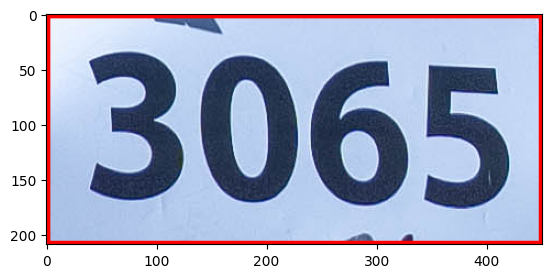

In [16]:
plt.imshow(img[y:y+h, x:x+w]);

In [10]:
im = img_PIL.crop((x, y, x+w, y+h))

In [11]:
im.show()